# Semantic segmentation of aerial imagery using a deep learning U-Net model

*by The-Huan Hoang*

*Word Count: 2035 (excluding code blocks and references)*

In [1]:
#Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Importing the libraries
try :
    import tensorflow
    import imageio.v2
    import PIL
except ImportError:
    !pip install tensorflow imageio PIL
import tensorflow as tf
import imageio.v2 as imageio
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Conv2DTranspose, concatenate, SeparableConv2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd    
import matplotlib.pyplot as plt
import seaborn as sns
import os
from urllib.parse import urlparse
from requests import get
import zipfile

# Set the seed for all random operations
randomseed = 2

## 1. About Semantic Segmentation and U-Net

**Semantic segmentation** is computer vision task of assigning a discrete label value to each pixel in an image to describe the nature of the objects present (e.g. road, sky, people, green). It is different from other computer vision tasks, such as *Image Classification* which labels the entire image (e.g. rural, city) , or *Instance Segmentation* which distinguishes individual subjects (e.g. each car, each building), or *Object Detection* which draws bounding box around each instance. It is widely used in diverse fields such as medical, robotics, and satellite imagery analysis where an understanding of what comprise the entire scene is important.

Whereas the traditional Convolutional Neural Network can predict single output from images, making it appropriate for Image Classification, a **Fully Convolutional Network** (or FCN, an specialised CNN architecture) can perform semantic segmentation tasks thanks to its final upsampling steps to the original image's dimension so that each pixel's label can be learned. 

There is an ever growing literature body on diverse FCN architectures for specific purposes. Among them, **U-Net** has garnered popularity due to its capabilities to effectively learn spatial patterns crucial for high-resolution image classification. 

![Source: Ronneberger et al. (2015)](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*f7YOaE4TWubwaFF7Z1fzNw.png)

### 1.1 What makes up a U-Net architecture?

Originally devised for used in biomedical field ([Ronneberger et al., 2015](https://arxiv.org/abs/1505.04597)), a U-Net architecture in its most basic form is made up of two main sections: the *decoders* and the *encoders*. The encoders capture features and contextual information from the input full-color image, while the decoders reconstruct those data into the output segmentation map. 

In both, there are multiple blocks made up of convolutional layers, and one block feeds into the next one with *maxpooling* (for encoders to reduce the spatial resolution) or *upsampling* (for decoders to revert back to the original resolution). Its signature quasi-symmetrical 'U'-shaped architecture also helps preserve spatial relationships between the input image and the ouput segmentation map by allowing 'skip-level' learning. 

This is different from other traditional FCN architectures where the upsampling is done only at the end, therefore not allowing for accurate pixel-based label learning. 

### 1.2 Training a U-Net architecture

A U-net can be improved by employing a pre-trained backbones so that the model does not have to learn from scratch. We could also experiment with different model parameters and tune various training hyperparameters.

While tuning hyperparameters such as epoch and batch size is relatively universal, tuning model parameters presents a more unique opportunity to harness the power of U-Net. [Lee et al. (2022)](https://www.mdpi.com/1999-4907/13/11/1813) in their work to improve U-Net for land cover classification specifically explored tuning different model parameters such as: 

- **Input Image size**
- **Model Depth**, i.e. how many layers of encoder/decoder blocks 
- **Block Width**, i.e. how many convolutional layers to include in each encoder/decoder block
- **Kernel Size**, i.e. the size of the filter used in the convolution operations

Moreover, [Wang et al. (2023)](https://www.sciencedirect.com/science/article/abs/pii/S0045790623001581#:~:text=UNet%20%5B16%5D%20is%20trained%20on,huge%20number%20of%20training%20data.), in their research on high-resolution remote sensing images semantic segmentation with Unet and SegNet, observed better remedy for the vanishing gradient problem when including a Batch Normalisation each the end of each block and using the **ELU** (Exponential Linear Unit) activation function instead of the more popularly used **ReLU** (Rectified Linear Unit).

### 1.3 Project Scope

Having understood the relevance of U-Net for semantic segmentation tasks, we will construct the model based on the architecture prescribed in ([Ronneberger et al., 2015](https://arxiv.org/abs/1505.04597)). Then, we will tune the relevant parameters in order to train the model to perform semantic segmentation tasks on a data set of drone aerial imagery. Lastly, we will assess its accuracy metrics and determine opportunities for future improvement. Due to the limited scope of this project, the chosen parameters for experimentation are:

1. Block Width: 2, 4 or 6 convolutional layers per block
2. Kernel Size: 3x3 or 5x5 
3. Activation function: ReLU or ELU

## 2. About the dataset

For this segmentation task, we will use a subset of the Urban Drone Dataset introduced in [Chen et al. (2018)](https://www.researchgate.net/publication/328682594_Large-Scale_Structure_from_Motion_with_Semantic_Constraints_of_Aerial_Images_First_Chinese_Conference_PRCV_2018_Guangzhou_China_November_23-26_2018_Proceedings_Part_I), and mader available on the authors' [GitHub](https://github.com/MarcWong/UDD?tab=readme-ov-file). 

This is a collection of drone image dataset collected at Peking University, Huludao city, Henan University and Cangzhou city. There are about 150 images and their annotated ground truth masks provided as follows:

|   Class  |Label|
|----------|--------|
|  Other   |   0    |
|  Facade  |   1    |
|  Road    |   2    |
|Vegetation|   3    |
|  Vehicle |   4    |
|   Roof   |   5    |

Lastly, although the provided dataset has additionally been split into 'train' and 'val' subsets, for more flexibility in train/test splitting later in the process, they have also been rejoined into one and hosted on Dropbox.

## 3. Loading and preprocessing the dataset

First, we will define some helper functions to download the dataset from remote, load the images and annotations, and preprocess the images to the configuration appropriate for the U-Net model. For data pre-processing, we essentially resize all source and annotated images into a uniform dimension, and then reshape it into arrays with height, width, and channels. For source images, there are 3 channels representing each of the RGB values, while for annotations there is one channel that contains the integer value of the pixel.

In [2]:
def cache_data(src: str, dest: str) -> str:
    url = urlparse(src)  # We assume that this is some kind of valid URL
    fn = os.path.split(url.path)[-1]  # Extract the filename
    dfn = os.path.join(dest, fn)  # Destination filename as path

    if not os.path.isfile(dfn):
        print(f"{dfn} not found, downloading!")
        path = os.path.split(dest)
        if len(path) >= 1 and path[0] != "":
            os.makedirs(os.path.join(*path), exist_ok=True)
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
        print("\tDone downloading...")
    else:
        print(f"Found {dfn} locally!")
    return dfn

In [3]:
def LoadImg (path1, path2):
    # Read the images folder like a list
    img_dataset = os.listdir(path1)
    ann_dataset = os.listdir(path2)

    # Make a list for images and annotations filenames
    img_list = []
    ann_list = []
    for file in img_dataset:
        img_list.append(file)
    for file in ann_dataset:
        ann_list.append(file)

    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding annots)
    img_list.sort()
    ann_list.sort()
    
    return img_list, ann_list

In [4]:
def PreprocessImg(img_list, ann_list, target_img, target_ann, path1, path2):

    # Pull the relevant dimensions for image and annotations
    n = len(img_list)                     # number of images
    img_h,img_w,img_c = target_img   # set target dimenions and channels of image for pre-processing
    ann_h,ann_w,ann_c = target_ann   # set target dimenions and channels of annotations for pre-processing
    
    # Define X and y as arrays of transformed images and annotations
    X = np.zeros((n,img_h,img_w,img_c), dtype=np.float32)
    y = np.zeros((n,ann_h,ann_w,ann_c), dtype=np.int32)
    
    # Resize images and annotations to target dimensions
    for file in img_list:
        # convert image into an array of desired shape (3 channels)
        index = img_list.index(file)
        path = os.path.join(path1, file)
        img = Image.open(path).convert('RGB')
        img = img.resize((img_h,img_w))
        img = np.reshape(img,(img_h,img_w,img_c)) 
        img = img/256
        X[index] = img
        
        # convert annotations into an array of desired shape (1 channel)
        ann_index = ann_list[index]
        path = os.path.join(path2, ann_index)
        ann = Image.open(path)
        ann = ann.resize((ann_h, ann_w))
        ann = np.reshape(ann,(ann_h,ann_w,ann_c)) 
        y[index] = ann
    
    return X, y

With the helper functions set up, we proceed to downloading, importing, and preprocessing the Urban Drone Dataset.

In [5]:
%%time
# Download the dataset from the link (4 minutes)
url = 'https://www.dropbox.com/scl/fi/yib54tq15a7orosvfc1vb/UDD6.zip?rlkey=h3ny22z1ohqemzvjqinx26i7v&dl=1'
dest = 'data'
dfn = cache_data(url, dest)

Found data\UDD6.zip locally!
CPU times: total: 0 ns
Wall time: 669 µs


In [6]:
# Unzip the dataset
with zipfile.ZipFile(dfn, 'r') as zip_ref:
    zip_ref.extractall(dest)

In [7]:
# Load the images and annotations
path1 = os.path.join('data','UDD6','src')
path2 = os.path.join('data','UDD6','gt')
img_files, ann_files = LoadImg (path1, path2)

# Define the desired shape for UNet
target_img = [128, 128, 3]
target_ann = [128, 128, 1]

# Process data
X, y = PreprocessImg(img_files,ann_files, target_img, target_ann, path1, path2)

Before continuing, let's visualise the ingested dataset, both the source image and the annotated ground truth to make sure everything has been done correctly.

Text(0.5, 0.98, 'Random Image and Annotation for sense check')

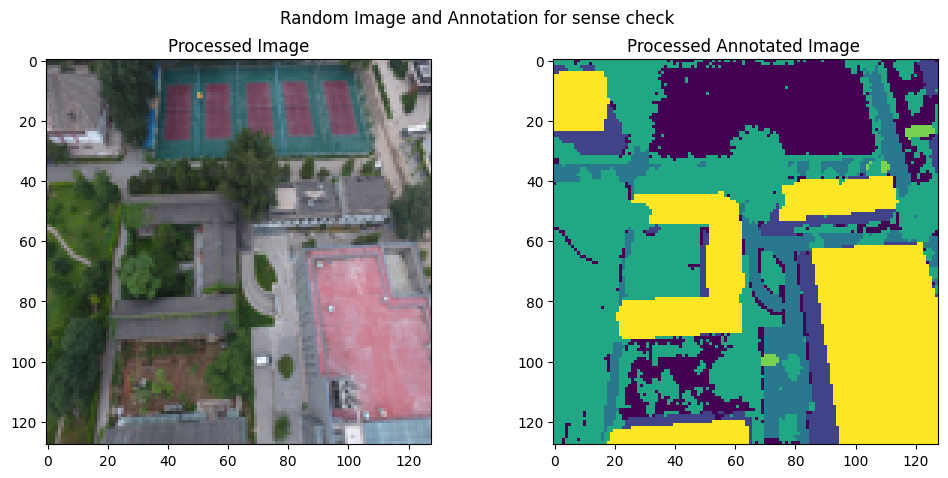

In [8]:
# Visualize the output at random
image_index = np.random.randint(0, X.shape[0])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(X[image_index])
ax[0].set_title('Processed Image')
ax[1].imshow(y[image_index,:,:,0])
ax[1].set_title('Processed Annotated Image ')
fig.suptitle('Random Image and Annotation for sense check')

We have managed to align the source and ground truth image into corresponding pairs, while also resizing them to a dimension of 128 x 128. The annotations seem to match the source image in coverage and value, so we are generally confident that the data is of high quality.

To check if there is over-representation of one class over others in the dataset, it is worth having an idea of the distribution of the 6 classes within the entire dataset to see if there are class weight imbalances that might introduce bias in the model. 

Text(0.5, 1.0, 'Distribution of classes in the annotations')

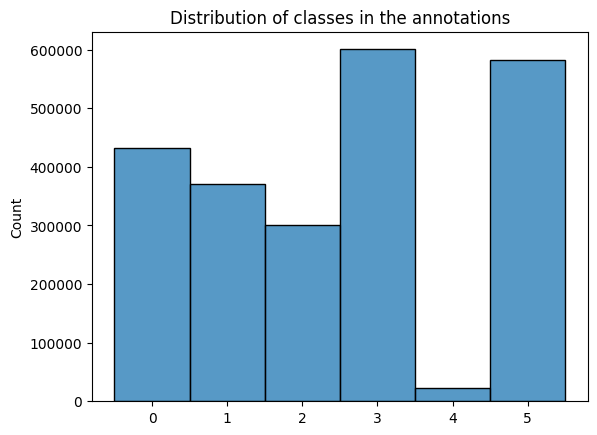

In [9]:
# Visualise distribution of classes in the annotations
sns.histplot( y.flatten(), discrete=True)
plt.title('Distribution of classes in the annotations')

Based on the histogram for label counts over the whole dataset, we can see that:

- Class 3 and 5 (Vegetation and Roof) have the highest occurences which makes sense for an aerial drone dataset.
- Class 0, 1, and 2 representing Other, Facade, and Road respectively have fewer. 
- Class 4 (Vehicle) have the least occurences.

The model may have the most data to learn and predict class 3 and 5, whereas its predicting class 4 may be limited. We will refer back to this after we have trained the model.

Moreover, if we visualise the distributions of each class among the images, we gain further insights: First, the mean counts of the labels relative to one another resemble the total count reflected in the histogram. This means, it is not the case that most images have a disproportionate count of certain labels. Second, there are some extreme outliers in Class 0, 2, and 5. While it is not an inherent issue, if these are disproportionately sorted into the test dataset, leaving fewer data to train the model on, their predictions might also be affected. Considering this is a rather small dataset, such inadvertent train/test split bias could introduce inaccuracies.

Text(0.5, 0.98, 'Distribution of each class per image')

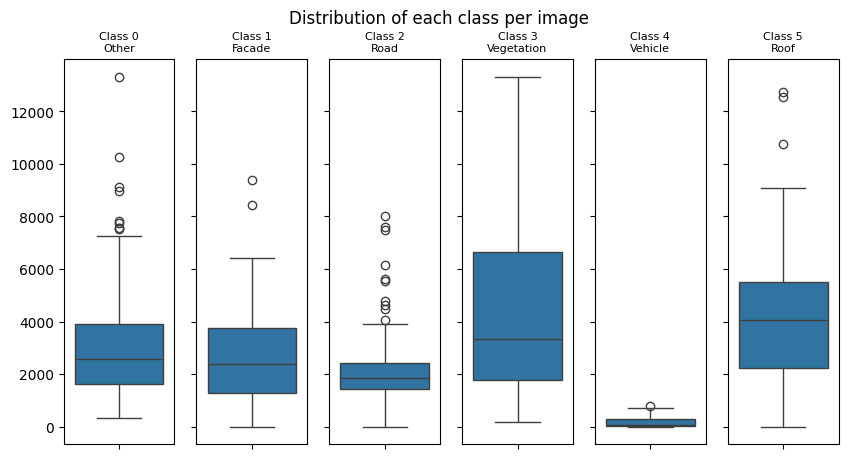

In [10]:
# Boxplot distribution of each class per image
classes = ['Other', 'Facade', 'Road', 'Vegetation', 'Vehicle', 'Roof']
fig, ax = plt.subplots(1, 6, figsize=(10, 5), sharey=True)
for i in range(6):
    sns.boxplot(data = np.sum(y == i, axis=(1,2,3)), ax=ax[i])
    #label each boxplot with class number and name
    ax[i].set_title(f'Class {i}\n{classes[i]}', fontsize=8)
    ax[i].set_xticklabels([''])
    ax[i].set_xlabel('')
fig.suptitle('Distribution of each class per image')

For our training, we will use a 80-20 split on the dataset.

In [11]:
# Split the data into training and testing sets (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomseed)

# Doublecheck array shapes
print("X-train Shape:", X_train.shape)
print("Y-train shape:", y_train.shape)
print("X-test Shape:", X_test.shape)
print("Y-test shape:", y_test.shape)
print(np.unique(y_train))
print(np.unique(y_test))

X-train Shape: (112, 128, 128, 3)
Y-train shape: (112, 128, 128, 1)
X-test Shape: (29, 128, 128, 3)
Y-test shape: (29, 128, 128, 1)
[0 1 2 3 4 5]
[0 1 2 3 4 5]


## 4. Build UNet architecture block by block

Despite its complexity, the U-Net is fundamentally a chain of blocks of different types of node layers, that feed forward to another in the prescribed U-shape. In order to build our U-Net, we will construct block-by-block the following:

- **Convolutional Block** the fundamental piece of larger blocks, consisting of 2 conv layers sandwiching a batch normalisation to improve training speed and stability
- **Encoder Block** puts the input image through convolutional layers before maxpooling to reduce the dimension. Each block returns the input for the next block, together with a skip layer input to be used in the corresponding decoder block.
- **Decoder Block** first upsamples the image from the previous layer to a bigger size before concatenating with the skip layer inputs from its corresponding encoder block. The image is then put through convolution layers and returns what will be the input for the next decoder block.

In [12]:
# Build the convolutional blocks layer
def convol_block(input,activation,n_filters, kernel):
    convol = Conv2D(n_filters, 
                    kernel_size=kernel, 
                    activation=activation, 
                    kernel_initializer='HeNormal', 
                    padding='same')(input)
    convol = BatchNormalization()(convol)
    convol = Conv2D(n_filters, 
                    kernel_size=kernel, 
                    activation=activation, 
                    kernel_initializer='HeNormal', 
                    padding='same')(convol)
    return convol

In [13]:
# Build encoder blocks
def EncoderBlock(input, n_conv , activation, n_filters, kernel, stride, dropout_prob=0.3, max_pooling=True):
    
    # Add convolution Layers 
    convol_input = input
    for i in range(n_conv):
        convol_input = convol_block(convol_input, activation, n_filters, kernel)
    convol = convol_input
    
    # Skip level connection serves as input to the symmetrical decoder layer      
    skip_block = convol

    # Dropout parameter added to prevent overfitting by randomly dropping a subset of input units during training.
    convol = Dropout(dropout_prob)(convol)
    
    # Max pooling layer to reduce the spatial dimensions of the output volume for the next layer.
    if max_pooling:
        next_block = MaxPooling2D(pool_size = (stride,stride))(convol)    
    else:
        next_block = convol

    return next_block, skip_block

In [14]:
# Build decoder blocks
def DecoderBlock(prev_layer_input, skip_layer_input, n_conv, activation,n_filters, kernel, stride):

    # Transpose layer to first increase the size of the image
    upsample = Conv2DTranspose(
                 n_filters,
                 (kernel,kernel), 
                 strides=(stride,stride),
                 padding='same')(prev_layer_input)

    # Merge inputs from the skip block and previous block
    merge = concatenate([upsample, skip_layer_input], axis=3)
   
    # Add Conv Layers with relu activation and HeNormal initialization. No batch normalization is needed in the decoder blocks.
    convol_input = merge
    for i in range(n_conv):
        convol_input = convol_block(convol_input, activation, n_filters, kernel)
    next_block = convol_input
    
    return next_block

We can now combine all encoder and decoder blocks in the prescribed sequence to form the **U-Net architecture**. Note that since model depth is not our intended parameter to tune, the architecture is built with a fixed 4 encoder blocks and 4 decoder blocks. Other parameters to tune (kernel, activation, number of convolution layers) can be accessed via the function arguments.

Besides the fundamental blocks, there are some additional ones of note: **Encoder block 5** serves as the transitional layer before decoding, therefore there is no more dimension reduction (maxpooling). **The last convolutional layer** is a 1x1 layer that uses a SoftMax activation to enable the classification of each pixel into each of the 6 labels.

Lastly, we can initiate the model to be used for our dataset by indicating that there are 6 classes and the input image size is 128 x 128 and in RGB (i.e., x 3). The model summary shows that there is indeed a U-shape in the dimensions of the input image change, with particular focus on blocks where the previous layer input is concatenated with the skip layer input, the defining feature of a U-Net.

In [15]:
def build_unet(n_classes, input_size, activation='elu', n_filters=32, n_conv=2, stride=2, kernel=3):

    # Input size represent the size of 1 image (the size used for pre-processing) 
    input = Input(input_size)
    
    # Encoder includes multiple blocks with increasing filter.
    eblock1 = EncoderBlock(input, n_conv, activation, n_filters, kernel, stride, max_pooling=True)
    eblock2 = EncoderBlock(eblock1[0], n_conv, activation, n_filters*2, kernel, stride, max_pooling=True)
    eblock3 = EncoderBlock(eblock2[0], n_conv, activation, n_filters*4, kernel, stride, max_pooling=True)
    eblock4 = EncoderBlock(eblock3[0], n_conv, activation, n_filters*8, kernel, stride, max_pooling=True)
    
    # Bottleneck layer, last encoder block, no maxpooling
    eblock5 = EncoderBlock(eblock4[0], n_conv, activation, n_filters*16, kernel, stride, max_pooling=False) 
    
    # Decoder includes multiple blocks with decreasing filters
    dblock6 = DecoderBlock(eblock5[0], eblock4[1], n_conv, activation, n_filters*8,kernel,stride)
    dblock7 = DecoderBlock(dblock6, eblock3[1], n_conv, activation, n_filters*4,kernel,stride)
    dblock8 = DecoderBlock(dblock7, eblock2[1], n_conv, activation, n_filters*2,kernel,stride)
    dblock9 = DecoderBlock(dblock8, eblock1[1], n_conv, activation, n_filters,kernel,stride)

    # Complete the model with a 1x1 Conv layer (merge channels) and softmax activation for classification
    output = Conv2D(n_classes, kernel_size=1, padding='same',activation='softmax')(dblock9)
    
    # Define the model
    model = Model(inputs=input, outputs=output)

    return model

In [16]:
test_model = build_unet(n_classes=6, input_size=target_img)
test_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ dropout_1[0][0] 

 Total params: 16,497,414 (62.93 MB)

 Trainable params: 16,491,526 (62.91 MB)

 Non-trainable params: 5,888 (23.00 KB)

## 5. Tuning and training the model

### 5.1 A manual approach to Grid Search

Initially, `GridSearchCV` in the `scikit-learn` library was to be used to easily tune the different hyperparameters for our model so that we can proceed to the full-scale training with the best headstart. However, it is incompatible with the U-Net built from scratch. Therefore, we introduced a more brute-force approach to GridSearch below, through which we will monitor the accuracy metric.

This is not an ideal solution but thanks to the limited scope (3 parameters to tune), and the relatively small size of our dataset, this can be an acceptable workaround. To make this approach somewhat more efficient, we also employ Early Stopping provided by Tensorflow/Keras. Lastly, since the manual GridSearch will only be done on 10% of the train dataset and for only 50 epochs, there might be bias in favour of models that manage to learn fast from the limited data subset in the beginning but may plateau after that.

In [17]:
# Set the parameter grid
params = {
    'kernel': [3,5],
    'n_conv': [1,2,3], # Note, 1 indicates a pair of conv layers sandwiching a batch normalization layer
    'activation': ['relu', 'elu'],
    }

# Reiterate the model building function with different parameters, and train the model, capture the accuracy and loss for each model
def tune_unet(X, y, params,epochs=100):
    
    # Store the parameters for each model
    kernels = []
    n_convs = []
    activations = []

    # Store the accuracy and loss for each model
    accuracies = []
    losses = []

    # Calculate the total number of iterations
    total = 1
    for key in params:
        total *= len(params[key])
    count = 0

    # Iterate over all the parameters

    early_stopping = EarlyStopping(patience=5) # stop training after 5 epochs of no improvement
   
    for activation in params['activation']:
            for n_conv in params['n_conv']:
                for kernel in params['kernel']:
                    
                    # Initialize, compile and train the model
                    model = build_unet(n_classes=6, activation=activation, n_conv=n_conv, kernel=kernel, input_size=target_img)
                    model.compile(optimizer=Adam(learning_rate=0.001), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
                    results = model.fit(X, y, epochs=epochs, callbacks=[early_stopping],verbose=0)
                        
                    # Store the parameters for each model
                    kernels.append(kernel)
                    n_convs.append(n_conv)
                    activations.append(activation)
                    
                    # Take the last accuracy and its corresponding loss
                    accuracies.append(results.history['accuracy'][-1])
                    losses.append(results.history['loss'][-1])
                                                      
                    count += 1
                    print(f'{count}/{total} done')
                    print(f'activation: {activation}, kernel: {kernel}, n_conv: {n_conv}, accuracy: {results.history['accuracy'][-1]}, loss: {results.history['loss'][-1]}')
    
    # Transform the results into a dataframe for easy analysis
    dict_results= {'activation': activations, 
                   'kernel': kernels, 
                   'n_conv': n_convs, 
                    'accuracy': accuracies,
                    'loss': losses}
    df_results = pd.DataFrame(dict_results)

    return df_results

In [18]:
# %%time
# # Randomly select a 10% subset of the train data to speed up the grid search
# X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=0.90, random_state=randomseed)
# # Perform the grid search
# manual_gridsearch = tune_unet(X_train_subset, y_train_subset, params, epochs=50) 

In [19]:
# # Transform this to a pivot table for better visualization
# pivot_accuracy = manual_gridsearch.pivot_table(index=['activation','n_conv'], columns=['kernel'], values='accuracy')
# pivot_loss = manual_gridsearch.pivot_table(index=['activation','n_conv'], columns=['kernel'], values='loss')

In [20]:
# # Plot the pivot tables
# fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# sns.heatmap(pivot_accuracy, annot=True, fmt=".3f", ax=ax[0])
# ax[0].set_title('Accuracy (Higher is better)')
# sns.heatmap(pivot_loss, annot=True, fmt=".3f", ax=ax[1])
# ax[1].set_title('Loss (Lower is better)')
# fig.suptitle('Accuracy and Loss for different parameters')

Due to the amount of time needed for this manual grid search (120+ mins), here is a summary of accuracy and loss results for different combinations of parameters from the last tuning performed. A key observation here is that more complex architecture (i.e, more conv layer) does not equal better performance. 

![](https://www.dropbox.com/scl/fi/oidbtvlyav0w65h7lxt7z/manualgrid_0.png?rlkey=1zio9o771lsfwz6gnww1ft6a8&dl=1)
![](https://www.dropbox.com/scl/fi/2loownfxdx6wd9v1b29r7/manualgrid.png?rlkey=0scrb8cag9svmtsioz519wqm9&dl=1)

### 5.2 Training the U-Net with the best parameters

With the results above, we will proceed to training the model in full with the following parameter values: 
- Kernel Size: 3
- Pairs of convolution layers per block: 1
- Activation function: ELU

Besides, we will run 200 training epochs with a batch size of 32. Since this is a multi-class segmentation task whereby the labels are integers, we shall use the Sparse Categorical Cross-entropy loss function. Also, the Adam optimiser is used by default. All these are also considered U-Net hyperparameters but their tuning is out of scope for this notebook.

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.3205 - loss: 1.8151 - val_accuracy: 0.2519 - val_loss: 2.4890
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5038 - loss: 1.2617 - val_accuracy: 0.2033 - val_loss: 5.9392
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5349 - loss: 1.1578 - val_accuracy: 0.2487 - val_loss: 8.2084
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5511 - loss: 1.1370 - val_accuracy: 0.2405 - val_loss: 24.3850
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5795 - loss: 1.0678 - val_accuracy: 0.2478 - val_loss: 7.4532
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5969 - loss: 1.0265 - val_accuracy: 0.2501 - val_loss: 22.1865
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6084 - loss: 1.0180 - val_accuracy: 0.2115 - val_loss: 31.2370
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6219 - loss: 0.9642 - val_accuracy: 0.2245 - val_loss: 22.3182
Ep

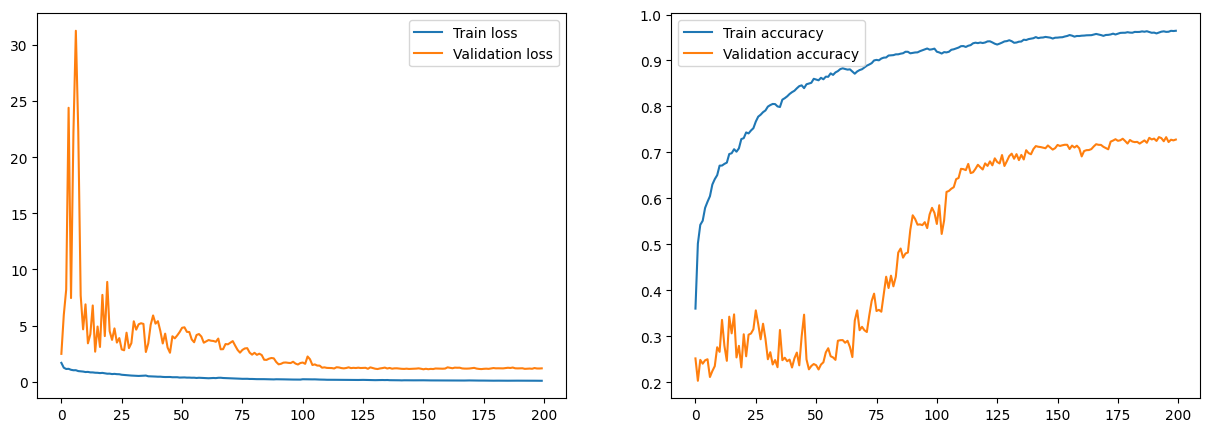

In [21]:
%%time
# Build the model with the best parameters
model = build_unet(n_classes=6, activation='elu', n_conv=1, kernel=3, input_size=target_img)

model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

results = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=200, 
                    validation_data=(X_test, y_test),
                    callbacks=[ModelCheckpoint('best_unet.keras', save_best_only=True)])

fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(results.epoch, results.history["loss"], label="Train loss")
ax_loss.plot(results.epoch, results.history["val_loss"], label="Validation loss")
ax_acc.plot(results.epoch, results.history["accuracy"], label="Train accuracy")
ax_acc.plot(results.epoch, results.history["val_accuracy"], label="Validation accuracy")
ax_loss.legend()
ax_acc.legend()

### 5.3 Evaluating the model's performance

Although the model learnt quickly from the train dataset, when validated with the test dataset, it plateaued at approximately **70% accuracy** on the test data after 150 epochs. 

The discrepancy between training and testing indicates that there may be overfitting creating bias. Possible reasons for high bias might be due to the limited data at hand, and also to the fact that the model is learning from scratch without relying on any pre-trained backbone. Another reason for high bias and variance may be due to the large number of trainable parameters in the complex architecture of a U-Net. 

In [22]:
# Create a table of OA, UA, PA, and F1 scores for each class

def Metrics():
    y_pred = model.predict(X_test)
    y_pred_argmax = np.argmax(y_pred, axis=3)
    y_test_argmax = y_test[:,:,:,0]

    # Flatten the arrays
    y_pred_argmax = y_pred_argmax.flatten()
    y_test_argmax = y_test_argmax.flatten()

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test_argmax, y_pred_argmax)

    # Calculate the overall accuracy
    oa = np.sum(np.diag(cm))/np.sum(cm)

    # Calculate the user's accuracy
    ua = np.diag(cm)/np.sum(cm, axis=0)

    # Calculate the producer's accuracy
    pa = np.diag(cm)/np.sum(cm, axis=1)

    # Calculate the F1 score
    f1 = 2*pa*ua/(pa+ua)

    # Create a table of the metrics
    df_metrics = pd.DataFrame({'Overall Accuracy': oa, 'User Accuracy': ua, 'Producer Accuracy': pa, 'F1 Score': f1}, index=['other','facade','road','vegetation','vehicle','roof'])

    return df_metrics

Metrics()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


,Overall Accuracy,User Accuracy,Producer Accuracy,F1 Score
other,0.727996,0.545652,0.605138,0.573857
facade,0.727996,0.708703,0.499547,0.586022
road,0.727996,0.646185,0.738955,0.689463
vegetation,0.727996,0.882313,0.917101,0.899371
vehicle,0.727996,0.695238,0.314333,0.432929
roof,0.727996,0.771106,0.753138,0.762016


The accuracy metric table below further provides insights on the prediction power of the model we have trained:
- **Class 0 (other)** has low User Accuracy (high false positives), possibly due to the large variances in the pixel RGB values of miscellaneous objects leading to many pixels being incorrectly predicted as 'other'
- **Class 1 (facade) and 4 (vehicle)** have low Producer Accuracy (high false negatives), possibly due to lack of data leading to incorrect labeling of other facades and vehicles unseen.
- **Class 2 (road), 3 (vegetation), and 5 (roof)** have UA and PA more in line with Overall Accuracy, possibly thanks to large enough train data for these values. For Class 2 (Road), the rather uniform RGB values of the source image made learning them much easier.

Finally, we shall visually inspect the prediction in contrast with the ground truth to deduce any obvious patterns or discrepancies.
We can confirm with the confusion matrix that Class 3 (vegetation) and 5 (roof) have more false positives owing to its relative larger class weight in the dataset over others. One possible fix is to initiate a distribution of class weights that is closer to the 'real' distribution, instead of using the 'he_normalised' initaliser.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


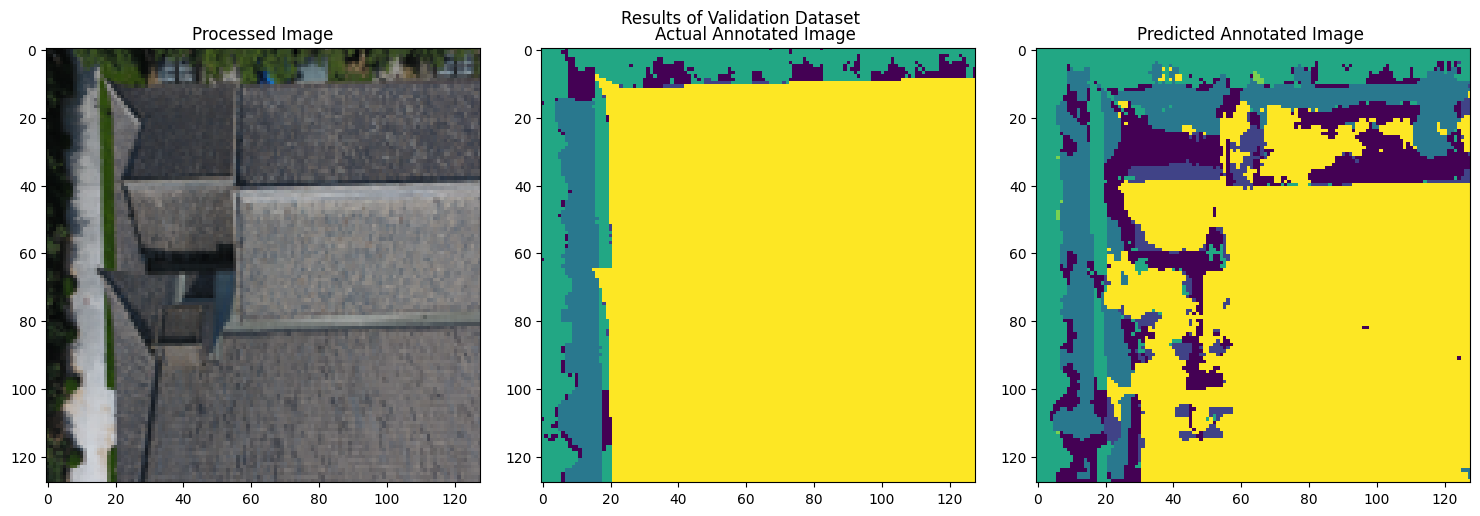

In [41]:
# Results of Validation Dataset
def VisualizeResults(index):
    img = X_test[index]
    img = img[np.newaxis, ...]
    pred_y = model.predict(img)
    pred_ann = tf.argmax(pred_y[0], axis=-1)
    pred_ann = pred_ann[..., tf.newaxis]
    fig, arr = plt.subplots(1, 3, figsize=(15, 5))
    arr[0].imshow(X_test[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_test[index,:,:,0])
    arr[1].set_title('Actual Annotated Image ')
    arr[2].imshow(pred_ann[:,:,0])
    arr[2].set_title('Predicted Annotated Image ')
    fig.suptitle('Results of Validation Dataset')
    fig.tight_layout()

# Visualise random results
index = np.random.randint(0, len(X_test))
VisualizeResults(index)

## 6. Discussion

In this notebook, we have constructed a U-Net from its building blocks using Tensorflow/Keras, based on [Ronneberger et al., 2015](https://arxiv.org/abs/1505.04597). We then used to perform semantic segmentation tasks on the Urban Drone Dataset with aerial imagery. Furthermore, we configured a brute-force parameter tuning function to choose the best parameters to initiate the models with. 

Despite acquiring high training accuracy, the discrepancy between training and validation shows signs of overfitting, requiring a reassessment of whether U-Net is the appropriate architecture for this task. In future iterations, improvements could be made in the following ways:
- For high resolution image dataset like this, instead of resizing (and thus also warping) the inputs, it may be better to crop them into smaller pieces so that we are not downsampling even before training the model. However, when cropping, one must also take care of patching the predictions together into the original dimension.
- Many of the images in the dataset are almost identical because these drone photos might have been taken too close together, which limits the variations needed to train the model. Therefore, image augmentation during pre-processing may be necessary to enrich the dataset further.
- This U-Net can benefit from a more resource-efficient GridSearch, to which we could introduce more hyperparameters to tune, such as optimisers, loss functions, batch size, epochs, etc., similar to what has been done by [Tran Thanh (2021)](https://www.researchgate.net/publication/355144817_Grid_Search_of_Convolutional_Neural_Network_model_in_the_case_of_load_forecasting)
- Besides U-Net, SegNet is also a highly recommended architecture for semantic segmentation tasks ([Wang et al. 2023](https://www.sciencedirect.com/science/article/abs/pii/S0045790623001581#:~:text=UNet%20%5B16%5D%20is%20trained%20on,huge%20number%20of%20training%20data.)). Therefore, a comparison between the two architectures side-by-side may offer further insights into what might work best for this aerial imagery dataset.

## References
- Chen, Yu & Wang, Yao & Lu, Peng & Yisong, Chen & Wang, Guoping. (2018). Large-Scale Structure from Motion with Semantic Constraints of Aerial Images: First Chinese Conference, PRCV 2018, Guangzhou, China, November 23-26, 2018, Proceedings, Part I. 347-359. 10.1007/978-3-030-03398-9_30. https://doi.org/10.1007/978-3-030-03398-9_30
- Lee, Yongkyu, Woodam Sim, Jeongmook Park, and Jungsoo Lee. 2022. "Evaluation of Hyperparameter Combinations of the U-Net Model for Land Cover Classification" Forests 13, no. 11: 1813. https://doi.org/10.3390/f13111813
- Olaf Ronneberger and Philipp Fischer and Thomas Brox. (2015) U-Net: Convolutional Networks for Biomedical Image Segmentation. 1505.04597. https://doi.org/10.1016/j.compeleceng.2023.108734
- Thanh, Tran. (2021). Grid Search of Convolutional Neural Network model in the case of load forecasting. Archives of Electrical Engineering. 70. 10.24425/aee.2021.136050. https://doi.org/10.24425/aee.2021.136050
- Xin Wang, Shihan Jing, Huifeng Dai, Aiye Shi. (2023). High-resolution remote sensing images semantic segmentation using improved UNet and SegNet,Computers and Electrical Engineering, Volume 108, 2023, 108734, ISSN 0045-7906. 10.1016/j.compeleceng.2023.108734. https://doi.org/10.1016/j.compeleceng.2023.108734
- Use of GitHub Copilot AI functionality.